In [4]:
#!pip install --user -U nltk
#!pip install seaborn
#!pip install wordcloud
#!pip install -U scikit-learn
#!pip install pytorch-transformers
#!pip install transformers[torch]
#!pip install evaluate

In [5]:
import pandas as pd
import numpy as np
import nltk
import re
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.feature_extraction.text import TfidfVectorizer

from datasets import Dataset

# nltk.download('stopwords')
# nltk.download('words')
# nltk.download("wordnet")
# nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.corpus import words
from nltk.stem import SnowballStemmer 
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

tqdm.pandas()

# 1. Basic Text Pre-Processing

Basic text preprocessing steps include a few essential tasks to further clean the available text data. It includes tasks like:-

1. Stop-Word Removal
2. Lower Casing
3. Stemming
4. Tokenization

Pre-processing of the text is not the main objective of this notebook that's why I am just covering a few basic steps in a brief

In [6]:
df=pd.read_excel("compiled_tweets.xlsx", sheet_name="compiled_tweets")
df.head()

,Annotator1,Anonator2,Text,Subjectivity,Polarity,Subjectivity_Anonator2,Polarity_Anonator2
0,Jia Kai,Yiting,Hey Kingz Crew I Just Went Live On Twitch Come...,1.0,1.0,1.0,1.0
1,Jia Kai,Yiting,little bit of dbd into apex legends (: https:/...,0.0,NaN,0.0,0.0
2,Jia Kai,Yiting,Tuesday night apex?! Lets get some damage! htt...,1.0,1.0,1.0,1.0
3,Jia Kai,Yiting,Watch tohrmentgames GO CRAZY ON APEX!! FOLLOW ...,1.0,1.0,1.0,1.0
4,Jia Kai,Yiting,3...2...1.. ðŸ”´LIVE!ðŸ”´\nðŸ‘ï¸ðŸ‘„ðŸ‘ï¸\...,0.0,NaN,1.0,0.0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11042 entries, 0 to 11041
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Annotator1              11042 non-null  object 
 1   Anonator2               11042 non-null  object 
 2   Text                    11042 non-null  object 
 3   Subjectivity            1061 non-null   float64
 4   Polarity                560 non-null    float64
 5   Subjectivity_Anonator2  871 non-null    float64
 6   Polarity_Anonator2      525 non-null    float64
dtypes: float64(4), object(3)
memory usage: 604.0+ KB


In [8]:
stopwords = stopwords.words('english')
words = set(words.words())
stemmer = SnowballStemmer('english')
lemmer = WordNetLemmatizer()
tokenizer = RegexpTokenizer(r'\w+')
# As this dataset is fetched from twitter so it has lots of people tag in tweets
# we will remove them 
tags = r"@\w*"


def preprocess_text(sentence:str, stem = False, lemmatize = False):
    
    #sentence = [re.sub(tags, "", sentence)]
    text = []
    for w in nltk.wordpunct_tokenize(sentence):
        w=w.lower()
        if w not in stopwords:
            word = stemmer.stem(w).lower() if stem else w
            if word.lower() in words:
                lemma_word = lemmer.lemmatize(word) if lemmatize else word
                text.append(lemma_word)
    return tokenizer.tokenize(" ".join(text))

In [9]:
print(f"Orignal Text : {df.Text[11]}")
print()
print(f"Preprocessed Text : {preprocess_text(df.Text[11], stem=True, lemmatize=True)}")

Orignal Text : Please enjoy this Apex Legends â€œMemetageâ€ ðŸ˜‚ #ApexLedgends #ApexLegends https://t.co/1MhQCkMuoD

Preprocessed Text : ['enjoy', 'apex', 'legend']


In [10]:
df['ProcessedText']=df['Text'].progress_apply(lambda x: preprocess_text(x, stem=True, lemmatize=True))

100%|██████████| 11042/11042 [00:04<00:00, 2610.90it/s]


In [11]:
df.head(5)

,Annotator1,Anonator2,Text,Subjectivity,Polarity,Subjectivity_Anonator2,Polarity_Anonator2,ProcessedText
0,Jia Kai,Yiting,Hey Kingz Crew I Just Went Live On Twitch Come...,1.0,1.0,1.0,1.0,"[hey, crew, went, live, twitch, come, chat, ha..."
1,Jia Kai,Yiting,little bit of dbd into apex legends (: https:/...,0.0,NaN,0.0,0.0,"[bit, apex, legend]"
2,Jia Kai,Yiting,Tuesday night apex?! Lets get some damage! htt...,1.0,1.0,1.0,1.0,"[night, apex, let, get]"
3,Jia Kai,Yiting,Watch tohrmentgames GO CRAZY ON APEX!! FOLLOW ...,1.0,1.0,1.0,1.0,"[watch, go, apex, follow]"
4,Jia Kai,Yiting,3...2...1.. ðŸ”´LIVE!ðŸ”´\nðŸ‘ï¸ðŸ‘„ðŸ‘ï¸\...,0.0,NaN,1.0,0.0,"[live, hop, bit, come, want, wit, decent]"


In [12]:
df['Number_of_Words'] = df['ProcessedText'].apply(len)
print(f"{(df['Number_of_Words'] == 0).sum()} of tweets has 0 word")
processed_df = df[df['Number_of_Words'] > 0].copy()
# drop the tweets with 0 useful words

736 of tweets has 0 word


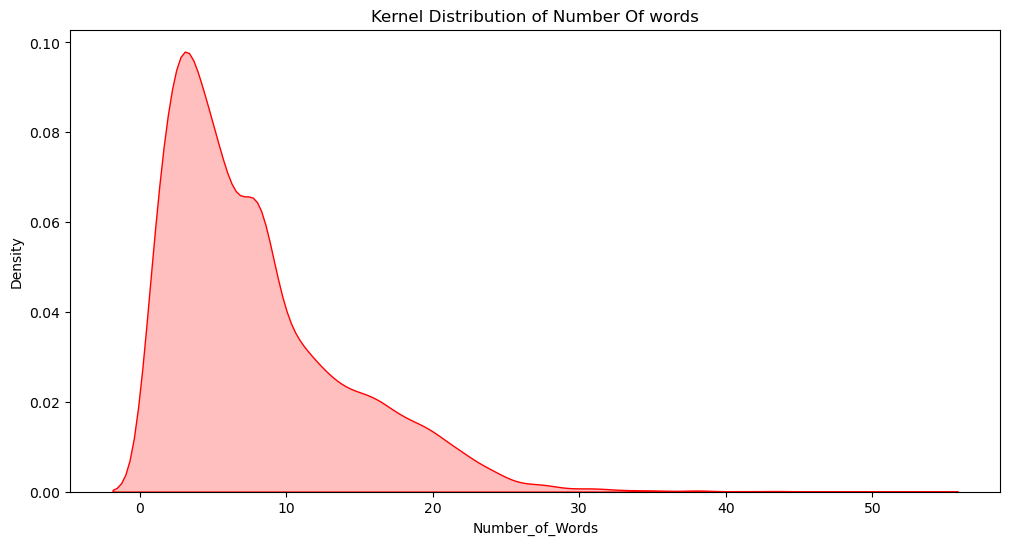

In [13]:
# to have an overview of the data
plt.figure(figsize=(12,6))
p1=sns.kdeplot(processed_df['Number_of_Words'], fill=True, color="r").set_title('Kernel Distribution of Number Of words')

We can see that overall, useful number of words in each tweet is quite small

In [14]:
processed_df['Number_of_Words'].describe()

count    10306.000000
mean         7.914031
std          6.024693
min          1.000000
25%          3.000000
50%          6.000000
75%         11.000000
max         53.000000
Name: Number_of_Words, dtype: float64

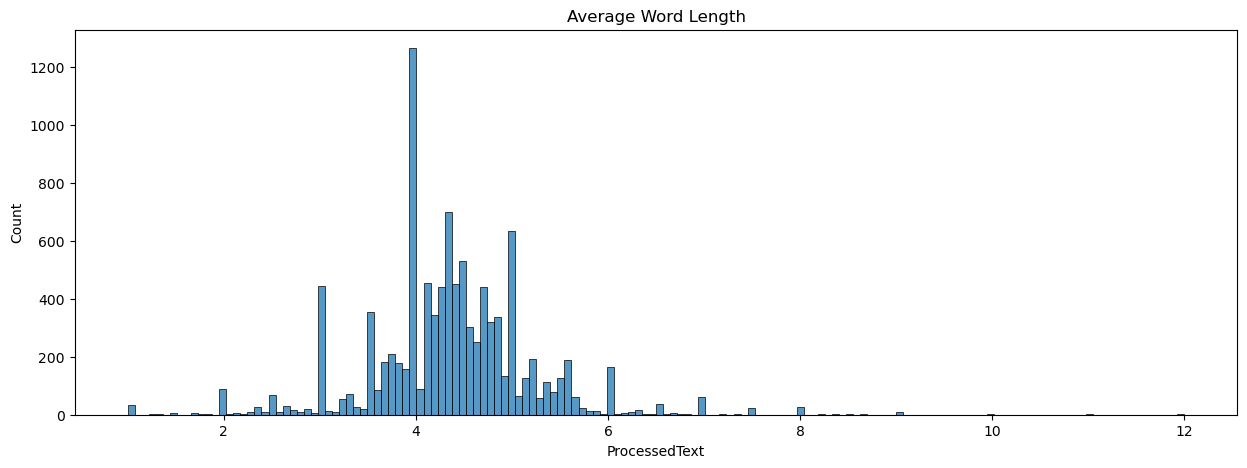

In [15]:
#compute the average length of words for each tweet
mean_word_len = processed_df['ProcessedText'].apply(lambda x : np.mean([len(i) for i in x]))
#plot the distribution of the average length of words
fig = plt.figure(figsize=(15, 5))
sns.histplot(data=mean_word_len)
plt.title("Average Word Length")
plt.show()

In [16]:
top = Counter([item for sublist in processed_df['ProcessedText'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
0,game,3245
1,b,2018
2,play,1675
3,team,1178
4,lost,1072
5,ark,1043
6,fortress,1028
7,get,1006
8,like,980
9,time,836


In [17]:
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(24.0,16.0), color = 'white',
                   title = None, title_size=40, image_color=False):

    wordcloud = WordCloud(background_color=color,
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=400, 
                    height=200,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask)
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud)
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off')
    plt.tight_layout()

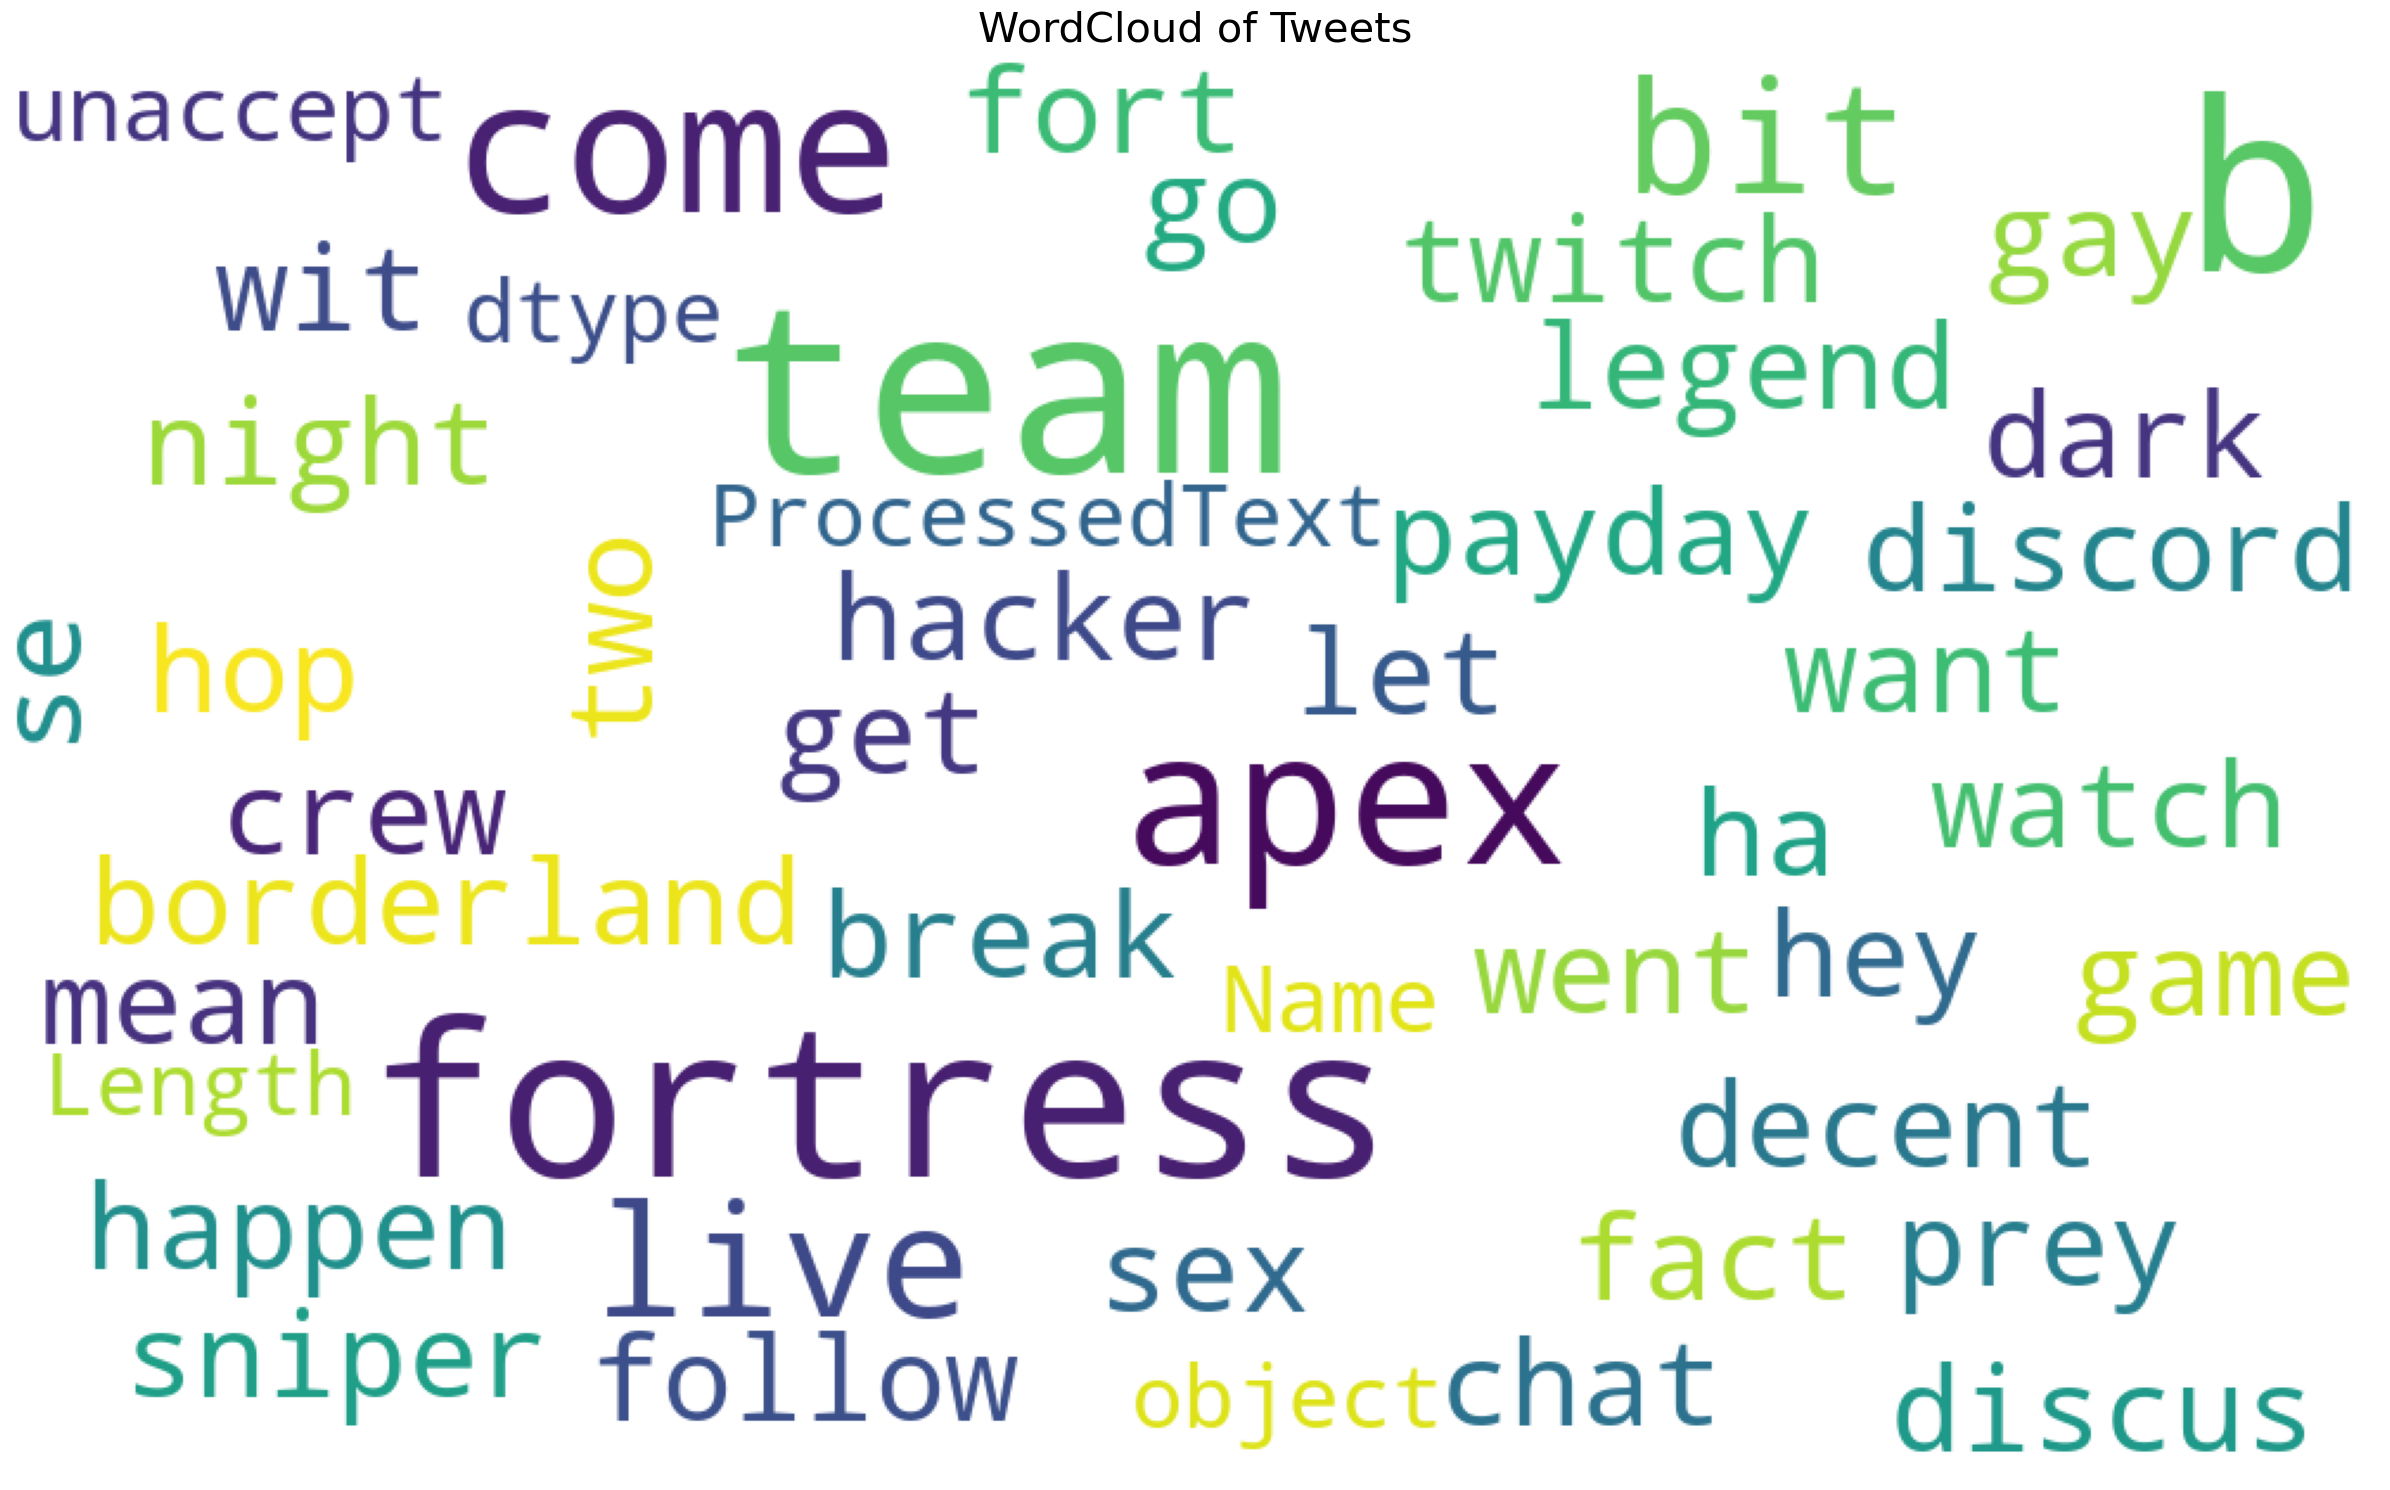

In [18]:
pos_mask = np.array(Image.new('RGB', (1000,600)))
plot_wordcloud(processed_df.ProcessedText,mask=pos_mask,color='white',max_font_size=100,title_size=30,title="WordCloud of Tweets")

# 2. Bert

Main idea: use train data to fine tune Bert model, and test data to evaluate

## 2.1 Preprocess

In [19]:
# before using tfidf, we need to split the dataset into train & test
processed_df['ProcessedSentence'] = processed_df['ProcessedText'].apply(lambda x: " ".join(x))
train_df = processed_df[processed_df['Subjectivity'].isna()].copy()
test_df = processed_df[processed_df['Subjectivity'].notna()].copy()
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

In [61]:
from transformers import AutoTokenizer

model_checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)
# tokenizer = AutoTokenizer.from_pretrained("bert-base-cased", cache=None)
def tokenize_function(examples):
    # return tokenizer(examples["ProcessedSentence"])
    return tokenizer(examples["ProcessedSentence"], padding="max_length", truncation=True)

# tokenized_datasets = train_dataset.map(tokenize_function, batched=True)
tokenized_datasets = train_dataset.map(tokenize_function, batched=True)#, num_proc=4)#, remove_columns=["ProcessedSentence"])
tokenized_tests = test_dataset.map(tokenize_function, batched=True)

loading configuration file config.json from cache at C:\Users\DELL/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e636cc8910bf2\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.23.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file vocab.txt from cache at C:\Users\DELL/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e636cc8910bf2\vocab.txt

In [62]:
tokenizer.decode(tokenized_datasets["input_ids"][1])

'[CLS] gas clutch apex twitch caustic game [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PA

In [65]:
from transformers import AutoModelForCausalLM
model = AutoModelForCausalLM.from_pretrained(model_checkpoint)

from transformers import Trainer, TrainingArguments
model_name = model_checkpoint
training_args = TrainingArguments(
    f"{model_name}-finetuned-tweets",
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    weight_decay=0.01,
    #output_dir="bert-pre-trained"
)

loading configuration file config.json from cache at C:\Users\DELL/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e636cc8910bf2\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.23.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at C:\Users\DELL/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e636cc8

In [67]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets,
    eval_dataset=tokenized_tests,
)

In [68]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `BertLMHeadModel.forward` and have been ignored: Number_of_Words, Polarity_Anonator2, Subjectivity, ProcessedText, ProcessedSentence, Polarity, Anonator2, Subjectivity_Anonator2, __index_level_0__, Text, Annotator1. If Number_of_Words, Polarity_Anonator2, Subjectivity, ProcessedText, ProcessedSentence, Polarity, Anonator2, Subjectivity_Anonator2, __index_level_0__, Text, Annotator1 are not expected by `BertLMHeadModel.forward`,  you can safely ignore this message.
c:\Users\DELL\miniconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 9261
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w.

ValueError: The model did not return a loss from the inputs, only the following keys: logits. For reference, the inputs it received are input_ids,token_type_ids,attention_mask.

### Train

In [216]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=2)

Downloading: 100%|██████████| 570/570 [00:00<00:00, 114kB/s]
Downloading: 100%|██████████| 436M/436M [00:16<00:00, 26.8MB/s] 
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSe

In [239]:
from transformers import TrainingArguments

training_args = TrainingArguments(output_dir="test_trainer", label_names="Subjectivity")

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [240]:
from evaluate import load
metric = load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

### Trainer

In [243]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(output_dir="test_trainer", evaluation_strategy="epoch")
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=X_train,
    eval_dataset=X_test,
    compute_metrics=compute_metrics,
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [244]:
trainer.train()

c:\Users\DELL\miniconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 9261
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3474

The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: Polarity_Anonator2, Number_of_Words, Anonator2, Text, Subjectivity, ProcessedText, __index_level_0__, Subjectivity_Anonator2, Polarity, Annotator1, ProcessedSentence. If Polarity_Anonator2, Number_of_Words, Anonator2, Text, Subjectivity, ProcessedText, __index_level_0__, Subjectivity_Anonator2

Unused: TF-IDF
 
TF-IDF, or term frequency-inverse document frequency, addresses missing-word issue, and aims to quantify the importance of a given word relative to other words in the document and in the corpus.

Main advantages and disadvantages of TF-IDF:
1. Harder implementatin
2. For every sentence of any length, there is a fixed-length encoding.
3. These high-dimensional representations are called feature vectors. As the vocabulary grows in size, so does the dimension.
4. It captures a bit of the semantics of the sentence.
5. They struggle with OOV terms.

In [141]:
def vectorize(text, maxx_features):
    vectorizer = TfidfVectorizer(max_features=maxx_features)
    X = vectorizer.fit_transform(text)
    return X


max_features = 2**12

X = vectorize(text, max_features)
X.shape